In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

import sys
sys.path.append("../../")
from utils import metrics
from utils.logger import Logger
import logging

In [2]:
def build_sequences(data, time_steps):
    if type(data) != np.ndarray:
        data = np.array(data).reshape(-1, 1)
    return np.array([[j for j in data[i:i + time_steps]] for i in range(0, len(data) - time_steps + 1)])[:,:,0]

## CALCE数据集

In [3]:
# 读取容量数据
calce_data_path = "../../data/processed_data/calce/calce_capacity.npy"
battery_names = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
calce_data = np.load(calce_data_path, allow_pickle=True)
b35 = calce_data[0].reshape(-1, 1)
b36 = calce_data[1].reshape(-1, 1)
b37 = calce_data[2].reshape(-1, 1)
b38 = calce_data[3].reshape(-1, 1)

# for i in (b35, b36, b37, b38):
#     plt.plot(i)

time_steps = 17 # 16个时间步输入，1个时间步输出
b35 = build_sequences(b35, time_steps)
b36 = build_sequences(b36, time_steps)
b37 = build_sequences(b37, time_steps)
b38 = build_sequences(b38, time_steps)

print("测试样本生成函数")
test = np.array(range(10)).reshape(-1, 1)
test = build_sequences(test, 4)
print(test)

测试样本生成函数
[[0 1 2 3]
 [1 2 3 4]
 [2 3 4 5]
 [3 4 5 6]
 [4 5 6 7]
 [5 6 7 8]
 [6 7 8 9]]


In [4]:
# import numpy as np

# a = [1, 2, 3, 4, 5]
# b = [6, 7, 8, 9, 10]
# c = [11, 12, 13, 14, 15]
# d = [16, 17, 18, 19, 20]

# datasets = [np.array(a), np.array(b), np.array(c), np.array(d)]

# for i, test_set in enumerate(datasets):
#     train_dataset = datasets[: i] + datasets[i + 1: ]
#     train_dataset = [j for d in train_dataset for j in d]
#     # train_sets = np.vstack([datasets[j] for j in range(len(datasets)) if j!=i])
#     print("Test set:", test_set)
#     print("Train sets:", train_dataset)
#     #do something with test_set and train_sets

Save log to: ../../logs/2023_06_15_22_51_calce_svr.log


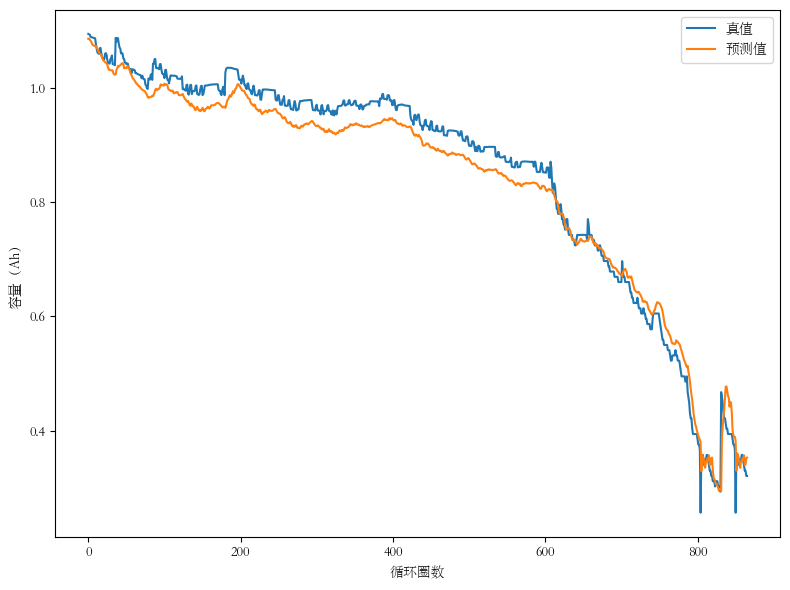

2023-06-15 22:51:32,241 - calce_svr - INFO - test dataset: CS2_35, maxE: 0.173213, mae: 0.027749, rmse:0.031600


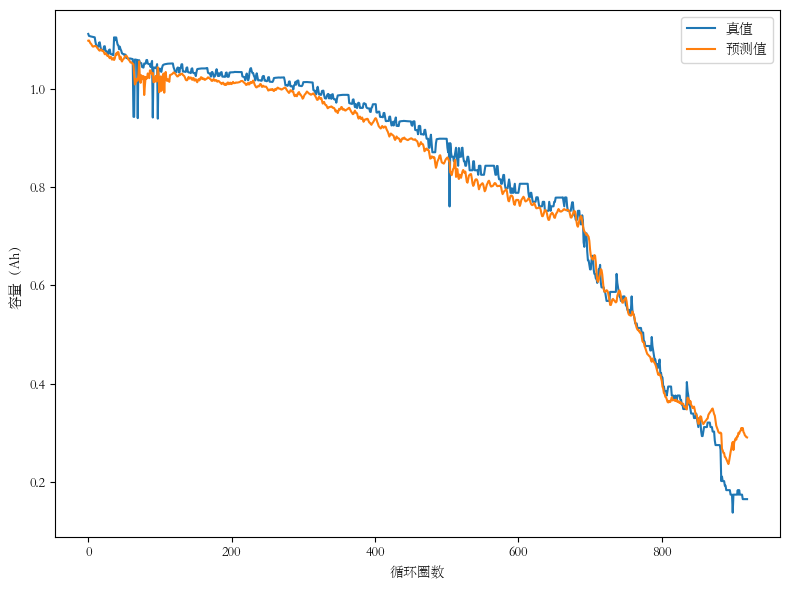

2023-06-15 22:51:32,936 - calce_svr - INFO - test dataset: CS2_36, maxE: 0.144716, mae: 0.024278, rmse:0.032347


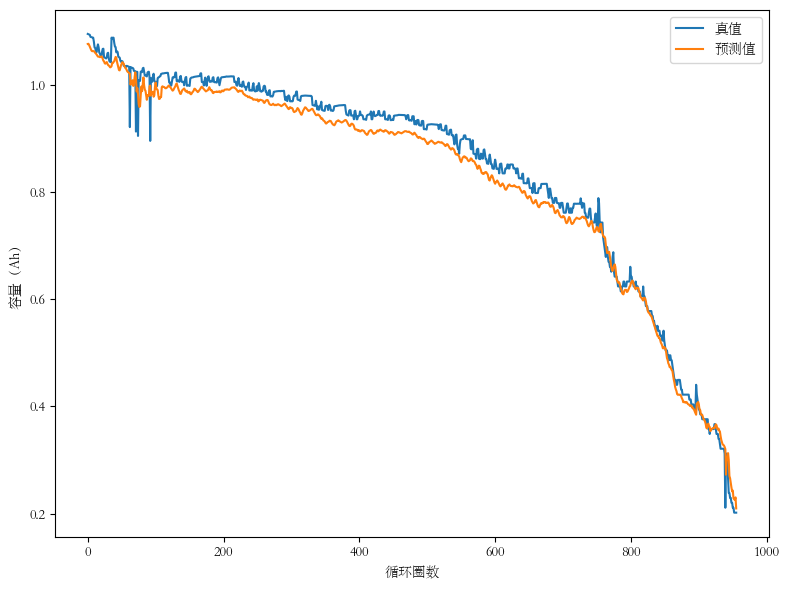

2023-06-15 22:51:33,645 - calce_svr - INFO - test dataset: CS2_37, maxE: 0.109326, mae: 0.021895, rmse:0.025152


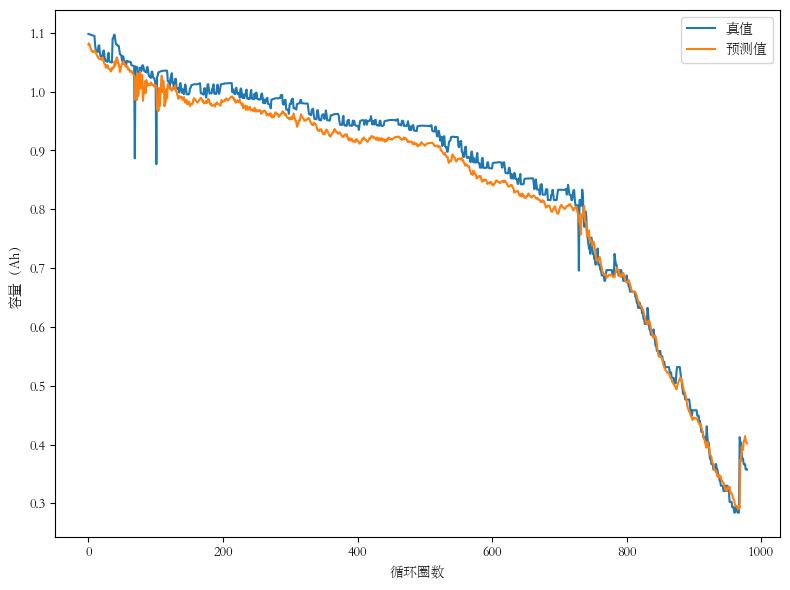

2023-06-15 22:51:34,387 - calce_svr - INFO - test dataset: CS2_38, maxE: 0.138677, mae: 0.020879, rmse:0.024601


In [5]:
logger = Logger(
        log_root_path="../../logs/",
        log_level=logging.DEBUG,
        logger_name="calce_svr"
    ).get_logger()

dataset = (b35, b36, b37, b38)
battery_names = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

for idx in range(len(dataset)):
    train_dataset = dataset[: idx] + dataset[idx + 1: ]
    train_dataset = np.array([j for i in train_dataset for j in i])
    test_dataset = dataset[idx]

    x_train, y_train = train_dataset[:,:time_steps - 1], train_dataset[:, [time_steps - 1]]
    x_test, y_test = test_dataset[:,:time_steps - 1], test_dataset[:, [time_steps - 1]]

    # 建模
    model = SVR(kernel="rbf", gamma=0.5, C=10, epsilon=0.05)
    # 预测
    model.fit(x_train, y_train[:,0])
    y_train_pred = model.predict(x_train).reshape(-1,1)
    y_test_pred = model.predict(x_test).reshape(-1,1)
    # print(y_train_pred.shape, y_test_pred.shape)

    plt.figure(figsize=(8, 6))
    plt.plot(y_test)
    plt.plot(y_test_pred)
    plt.legend(["真值", "预测值"])
    plt.xlabel("循环圈数")
    plt.ylabel("容量（Ah）")
    save_path = f"../../assets/thesis_figures/chapter_3/calce_{battery_names[idx]}_svr.jpg"
    plt.savefig(save_path, dpi=1000, bbox_inches="tight")
    plt.tight_layout()
    plt.show()

    np.save(f"../../results/calce_{battery_names[idx]}_svr.npy", np.array(y_test_pred))

    maxE, mae, rmse = metrics.evaluation(y_test, y_test_pred)
    logger.info(f"test dataset: {battery_names[idx]}, maxE: {maxE:7.6f}, mae: {mae:7.6f}, rmse:{rmse:7.6f}")

## NASA数据集

Save log to: ../../logs/2023_06_15_22_51_nasa_svr.log


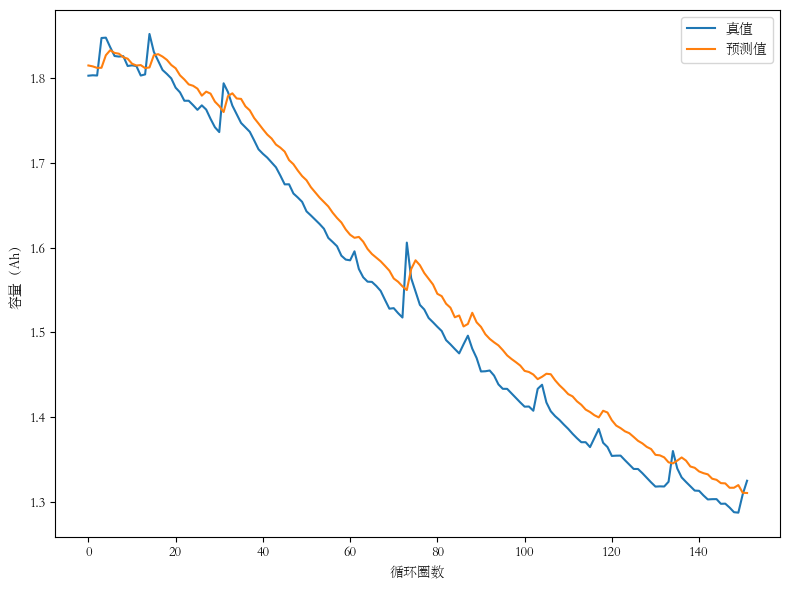

2023-06-15 22:51:35,098 - nasa_svr - INFO - test dataset: B0005, maxE: 0.055918, mae: 0.029598, rmse:0.032088


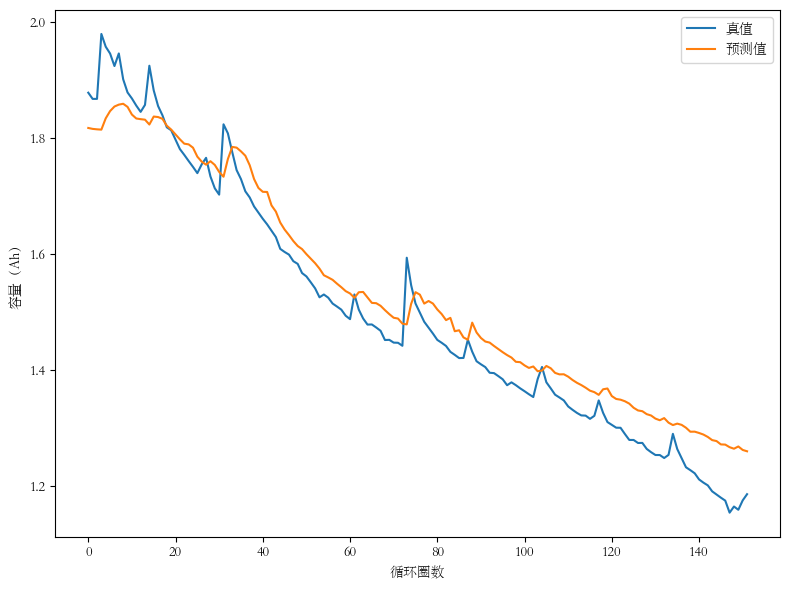

2023-06-15 22:51:35,779 - nasa_svr - INFO - test dataset: B0006, maxE: 0.165065, mae: 0.048098, rmse:0.054280


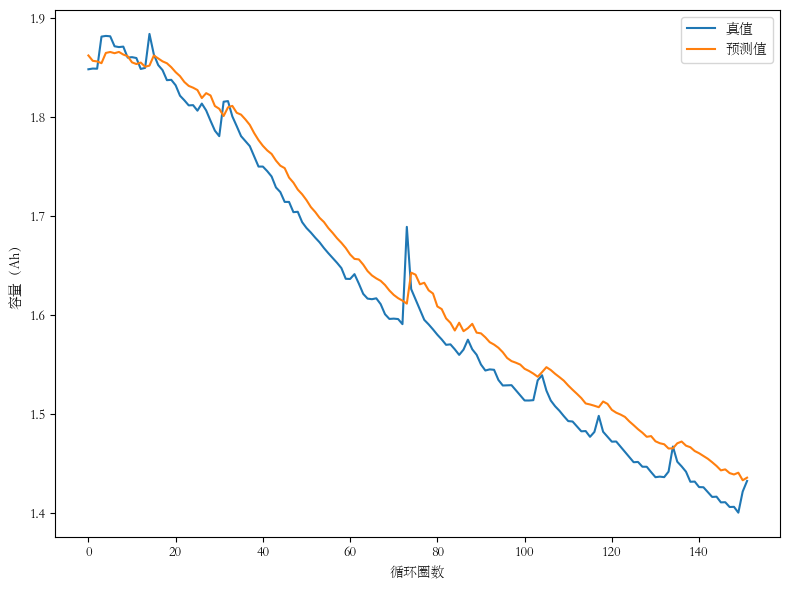

2023-06-15 22:51:36,462 - nasa_svr - INFO - test dataset: B0007, maxE: 0.077455, mae: 0.024318, rmse:0.026477


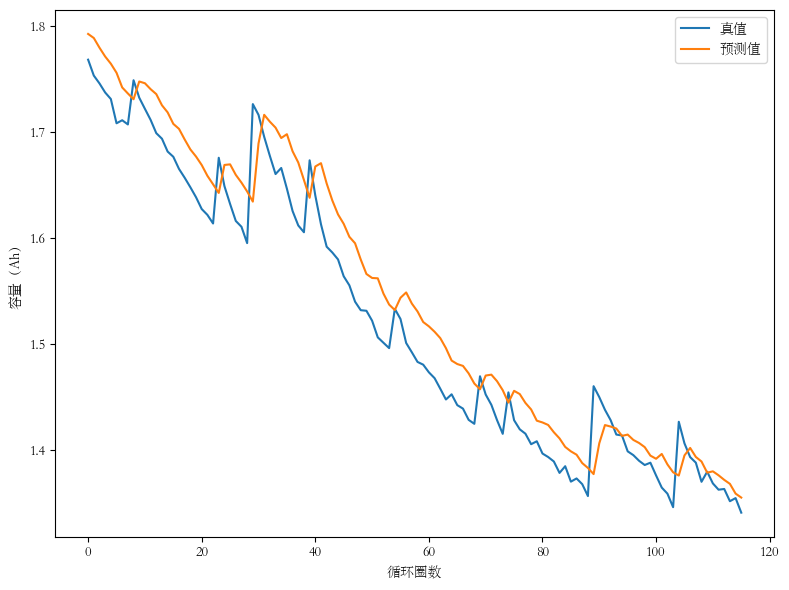

2023-06-15 22:51:37,138 - nasa_svr - INFO - test dataset: B0018, maxE: 0.092054, mae: 0.032140, rmse:0.035924


In [6]:
logger = Logger(
        log_root_path="../../logs/",
        log_level=logging.DEBUG,
        logger_name="nasa_svr"
    ).get_logger()

# 读取容量数据
battery_names = ["B0005", "B0006", "B0007", "B0018"]
nasa_data_path = "../../data/processed_data/nasa/nasa_capacity.npy"
nasa_data = np.load(nasa_data_path, allow_pickle=True)
b05 = nasa_data[0].reshape(-1, 1)
b06 = nasa_data[1].reshape(-1, 1)
b07 = nasa_data[2].reshape(-1, 1)
b18 = nasa_data[3].reshape(-1, 1)

time_steps = 17 # 16个时间步输入，1个时间步输出
b05 = build_sequences(b05, time_steps)
b06 = build_sequences(b06, time_steps)
b07 = build_sequences(b07, time_steps)
b18 = build_sequences(b18, time_steps)

dataset = (b05, b06, b07, b18)

for idx in range(len(dataset)):
    train_dataset = dataset[: idx] + dataset[idx + 1: ]
    train_dataset = np.array([j for i in train_dataset for j in i])
    test_dataset = dataset[idx]

    x_train, y_train = train_dataset[:,:time_steps - 1], train_dataset[:, [time_steps - 1]]
    x_test, y_test = test_dataset[:,:time_steps - 1], test_dataset[:, [time_steps - 1]]

    # 建模
    model = SVR(kernel="rbf", gamma=0.5, C=10, epsilon=0.05)
    # 预测
    model.fit(x_train, y_train[:,0])
    y_train_pred = model.predict(x_train).reshape(-1,1)
    y_test_pred = model.predict(x_test).reshape(-1,1)
    # print(y_train_pred.shape, y_test_pred.shape)

    plt.figure(figsize=(8, 6))
    plt.plot(y_test)
    plt.plot(y_test_pred)
    plt.legend(["真值", "预测值"])
    plt.xlabel("循环圈数")
    plt.ylabel("容量（Ah）")
    save_path = f"../../assets/thesis_figures/chapter_3/nasa_{battery_names[idx]}_svr.jpg"
    plt.savefig(save_path, dpi=1000, bbox_inches="tight")
    plt.tight_layout()
    plt.show()

    np.save(f"../../results/nasa_{battery_names[idx]}_svr.npy", np.array(y_test_pred))

    maxE, mae, rmse = metrics.evaluation(y_test, y_test_pred)
    logger.info(f"test dataset: {battery_names[idx]}, maxE: {maxE:7.6f}, mae: {mae:7.6f}, rmse:{rmse:7.6f}")